# Creating a DQN LSTM Agent

In [6]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [7]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

In [8]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

/home/wxzhang/anaconda3/envs/cv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we will create a DQN agent that uses LSTM rather than past frames as history. We augment the experience replay to contain previous few (state, action, reward, next state) tuples rather than just one (state, action, reward, next state) tuple so it can work with LSTMs. Use the previous tuples to generate the current hidden and context vector for LSTM. 
Esentially, when you get a sample from replay buffer during training, start with the first tuple and generate hidden and context vector from this and pass it onto the next tuple. Do so consequitively till you reach the last tuple, where you will make Q value predictions.
Training loop remains nearly the same.

In [9]:
from agent_lstm import Agent_LSTM
agent = Agent_LSTM(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

episode: 0   score: 0.0   memory length: 122   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 1.0   memory length: 290   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 0.5
episode: 2   score: 1.0   memory length: 462   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 0.6666666666666666
episode: 3   score: 0.0   memory length: 585   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.5
episode: 4   score: 1.0   memory length: 753   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 0.6
episode: 5   score: 2.0   memory length: 951   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 0.8333333333333334
episode: 6   score: 1.0   memory length: 1120   epsilon: 1.0    steps: 169    lr: 0.0001     evaluation reward: 0.8571428571428571
episode: 7   score: 1.0   memory length: 1271   epsilon: 1.0    steps: 151    lr: 0.0001     evaluation reward: 0.875
episode: 8   score: 1.0   memor

RuntimeError: shape '[-1, 5, 512]' is invalid for input of size 512

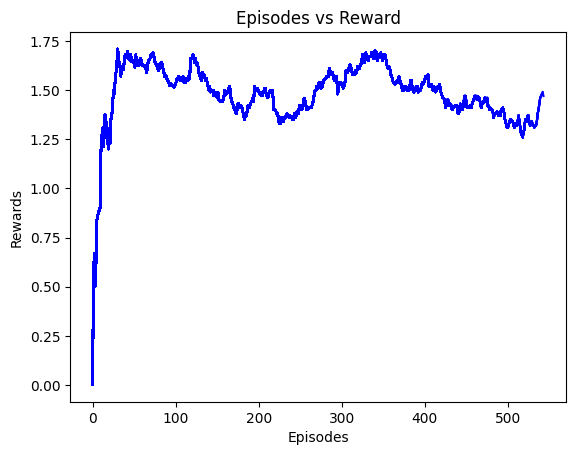

In [10]:
HISTORY_SIZE = 1
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    hidden = None

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action, hidden = agent.get_action(np.float32(history[:1, :, :]) / 255., hidden)
        state = next_state
        next_state, reward, terminated, truncated, info = env.step(action + 1)
        done = terminated or truncated
        
        frame_next_state = get_frame(next_state)
        history[1, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
        score += reward
        history[:1, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn_lstm.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


# Visualize Agent Performance

In [ ]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_lstm_latest.pth")

In [ ]:
from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()